In [1]:
#Imports
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from utils import save_checkpoint, load_checkpoint, print_examples
from get_loader import get_loader
from model import CNNtoRNN

In [2]:
def train():
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder="flickr8k/images",
        annotation_file="flickr8k/captions.txt",
        transform=transform,
        num_workers=2,
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = False
    train_CNN = False

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 100

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):

        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)
        loop = tqdm(train_loader, total=len(train_loader), leave=False)
        for idx, (imgs, captions) in enumerate(loop):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

            loop.set_postfix(loss = loss.item())
        
    # Uncomment the line below to see a couple of test cases
    print_examples(model, device, dataset)


  0%|          | 0/1265 [00:00<?, ?it/s]C:\Users\matha\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


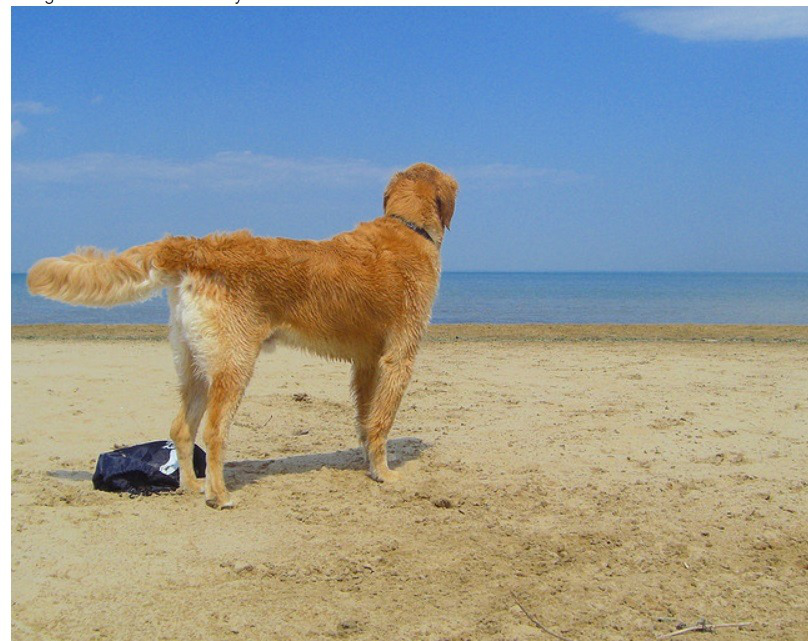

Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a brown dog is running through the water with a stick in its mouth . <EOS>


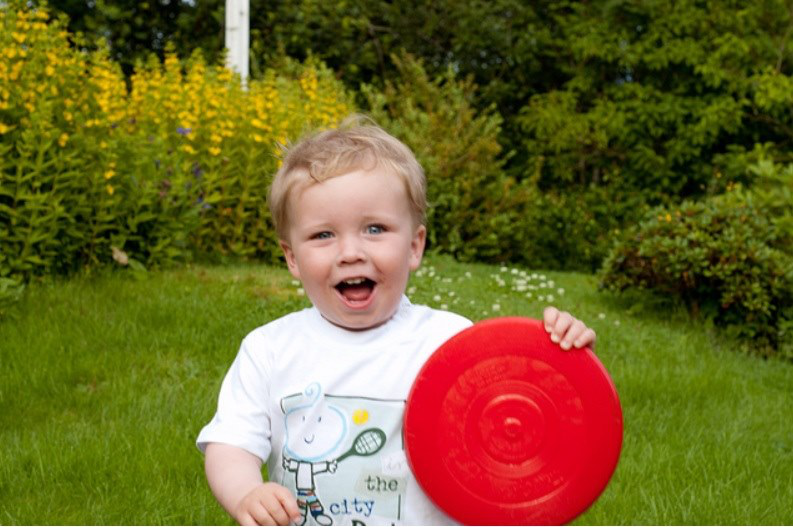

Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a young girl in a pink shirt is swinging on a rope swing . <EOS>


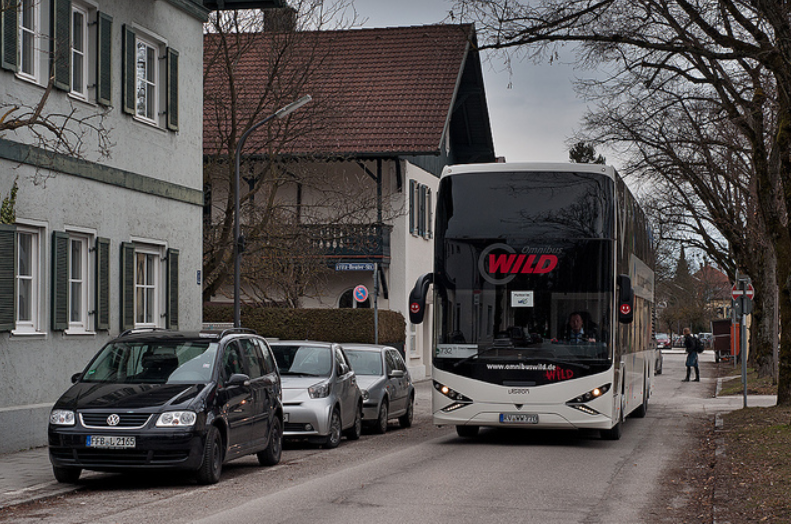

Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a blue shirt is walking past a parking lot . <EOS>


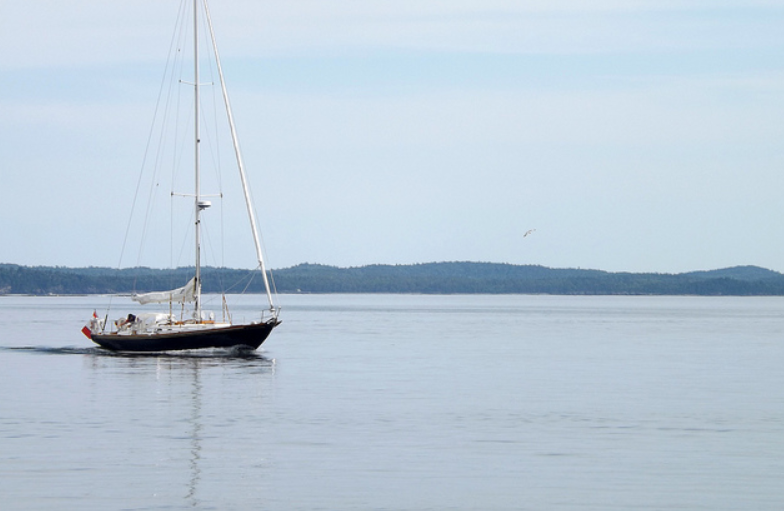

Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a man is rowing a boat on a lake . <EOS>


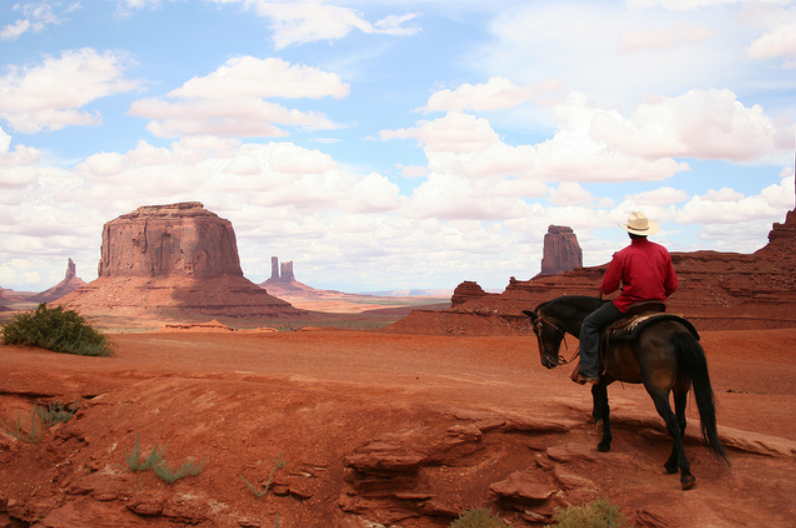

Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man and a dog are standing on a beach . <EOS>


In [3]:
train()
